For the final project, I’d like you to take this as an opportunity not only to test your knowledge in regression and machine learning but also to explore a topic that interests you a bit more deeply. To do this, I’d like you to find a labeled dataset with either a continuous (regression) or categorical response variable (classification). 

If you’re performing regression, I’d like you to try out the linear regression techniques we discussed throughout the first 10 modules. This will include checking assumptions, performing relevant transformations, potentially utilizing shrinkage or dimensionality reduction methods, and ensuring appropriate sampling is performed (i.e. train/test/val split and/or cross-validation). If you decide to go the classification route, I’d like you to explore logistic regression (potentially multinomial logistic regression if there are multiple categories) and check all of the same topics mentioned above. Also, make sure to interpret your results (i.e. coefficients) to the best of your ability.

It’s not unlikely that the above analysis won’t lead to strong predictive accuracy (there’s always that tradeoff between accuracy and interpretability) so I’d also like you to try using two or more non-parametric methods. These include all of the topics discussed in Modules 11 through 14, each of which has both a classification and regression implementation. Make sure to use cross-validation (or a validation set if your dataset is too large) to tune the hyperparameters and select the best model.

Once you have settled on a final model (either parametric or non-parametric), apply it to your test data and report the accuracy. Discuss your final results and whether there is evidence of overfitting or underfitting. You’ll also need to determine the appropriate evaluation metric. That may be accuracy but, depending on the class imbalance or dataset, precision or recall may be more appropriate.

https://www.kaggle.com/datasets/anujshah0311/healthcare-dataset-stroke-data

My goal is to determine which metrics are the most helpful in prediciting stroke outcomes. 

In [234]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from collections import Counter
import numpy as np
from math import exp
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, classification_report,accuracy_score,mean_squared_error,recall_score
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split,RepeatedKFold
import time
from collections import Counter, defaultdict
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler,scale
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet,LogisticRegressionCV, LogisticRegression
import warnings
import os

%matplotlib inline

In [235]:
df = pd.read_csv("/content/healthcare-dataset-stroke-data.csv") #read in csv file
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [236]:
df= df.drop(['id'],axis =1)
df =df.dropna()
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [237]:
Counter(df['stroke'])

Counter({1: 209, 0: 4700})

In [238]:
4700/(4700+209) #determine baseline accuracy

0.9574251375025463

In [239]:
splits = np.random.choice(a = 3, size = df.shape[0], p = [0.7,0.15,0.15])
df = pd.get_dummies(data=df, drop_first=True)

In [240]:
df.columns.get_loc('stroke')

5

In [241]:
col = df['stroke']
df = df.drop(['stroke'],axis =1)

In [242]:
df['stroke']=col
df.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke
0,67.0,0,1,228.69,36.6,1,0,1,0,1,0,0,1,1,0,0,1
2,80.0,0,1,105.92,32.5,1,0,1,0,1,0,0,0,0,1,0,1
3,49.0,0,0,171.23,34.4,0,0,1,0,1,0,0,1,0,0,1,1
4,79.0,1,0,174.12,24.0,0,0,1,0,0,1,0,0,0,1,0,1
5,81.0,0,0,186.21,29.0,1,0,1,0,1,0,0,1,1,0,0,1


In [243]:
df_train = df.iloc[np.where(splits == 0)[0],:]
df_val = df.iloc[np.where(splits == 1)[0],:]
df_test = df.iloc[np.where(splits == 2)[0],:]

In [244]:
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(3408, 17)
(763, 17)
(738, 17)


In [245]:
df.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke
0,67.0,0,1,228.69,36.6,1,0,1,0,1,0,0,1,1,0,0,1
2,80.0,0,1,105.92,32.5,1,0,1,0,1,0,0,0,0,1,0,1
3,49.0,0,0,171.23,34.4,0,0,1,0,1,0,0,1,0,0,1,1
4,79.0,1,0,174.12,24.0,0,0,1,0,0,1,0,0,0,1,0,1
5,81.0,0,0,186.21,29.0,1,0,1,0,1,0,0,1,1,0,0,1


In [246]:
xtrain = df_train.iloc[:,:-1] #separate into train, val, test sets
ytrain = df_train.iloc[:,-1]
xtest = df_test.iloc[:,:-1]
ytest = df_test.iloc[:,-1]

In [247]:
xval = df_val.iloc[:,:-1]
yval = df_val.iloc[:,-1]

In [248]:
xval

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
28,69.00,0,1,195.23,28.3,1,0,1,0,0,1,0,1,0,0,1
30,57.00,1,0,212.08,44.2,1,0,1,0,1,0,0,1,0,0,1
32,82.00,1,0,196.92,22.2,0,0,1,0,0,1,0,1,0,1,0
33,80.00,0,1,252.72,30.5,1,0,1,0,0,1,0,1,1,0,0
52,79.00,0,1,127.29,27.7,0,0,1,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5079,1.72,0,0,77.28,17.1,1,0,0,0,0,0,1,1,0,0,0
5082,44.00,0,0,72.03,37.5,0,0,1,0,1,0,0,0,0,0,1
5091,59.00,1,0,95.05,30.9,1,0,1,0,1,0,0,0,0,1,0
5094,13.00,0,0,82.38,24.3,1,0,0,0,0,0,1,1,0,0,0


Elastic Net

In [249]:
xtrain

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,0,1,0,1,0,0,1,1,0,0
2,80.0,0,1,105.92,32.5,1,0,1,0,1,0,0,0,0,1,0
3,49.0,0,0,171.23,34.4,0,0,1,0,1,0,0,1,0,0,1
4,79.0,1,0,174.12,24.0,0,0,1,0,0,1,0,0,0,1,0
5,81.0,0,0,186.21,29.0,1,0,1,0,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5101,45.0,0,0,97.95,24.5,0,0,1,0,1,0,0,1,0,0,0
5102,57.0,0,0,77.93,21.7,0,0,1,0,1,0,0,0,0,1,0
5103,18.0,0,0,82.85,46.9,0,0,0,0,1,0,0,1,0,0,0
5106,81.0,0,0,125.20,40.0,0,0,1,0,0,1,0,1,0,1,0


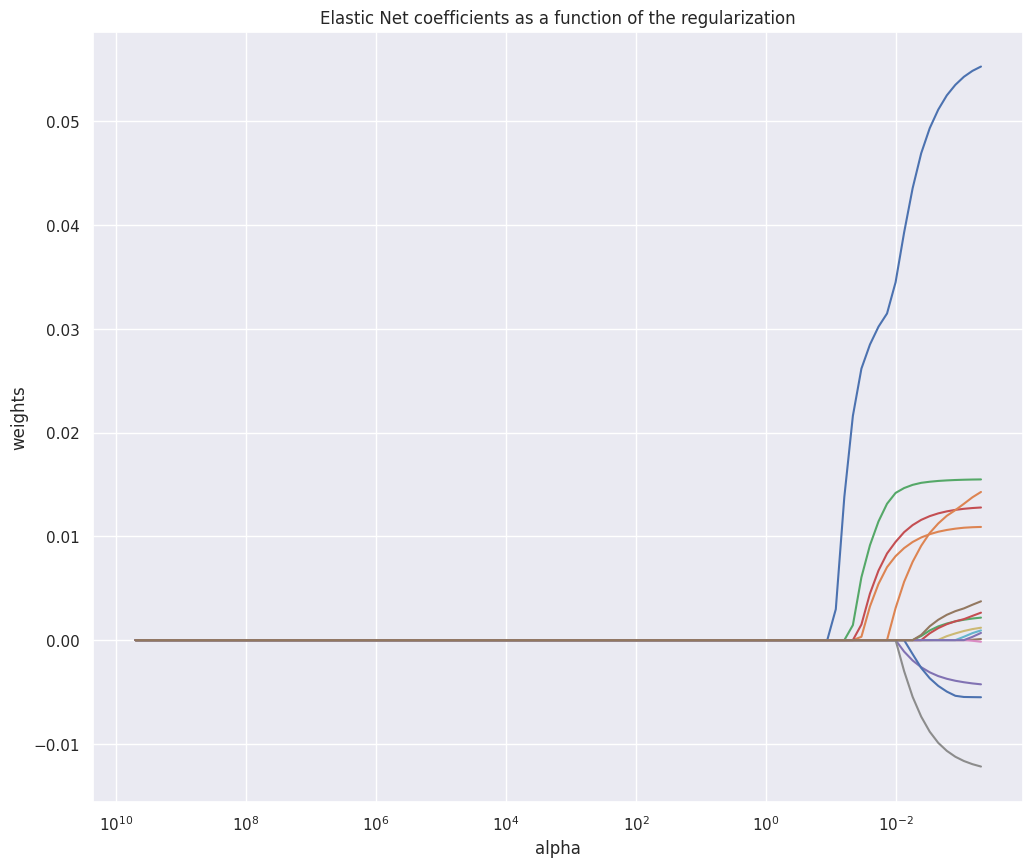

In [250]:
alphas = 10**np.linspace(10,-3,100)*0.5
l1_ratio = 0.5 #mixing parameter

en = ElasticNet(max_iter=10000)
coefs = []

for a in alphas:
    en.set_params(alpha=a, l1_ratio=l1_ratio)
    en.fit(scale(xtrain), ytrain)
    coefs.append(en.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Elastic Net coefficients as a function of the regularization');

In [251]:
elastic_net_classifier = LogisticRegressionCV(cv=5, penalty='elasticnet', l1_ratios=[0.1, 0.5, 0.9], solver='saga')
elastic_net_classifier.fit(xtrain, ytrain)
elastic_net_classifier.score(xval, yval)
# Train the models

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means 

0.9554390563564875

In [252]:
elastic_net_classifier.score(xval, yval)

0.9554390563564875

In [253]:
pd.Series(elastic_net_classifier.coef_.flatten(), index=xtrain.columns)

age                               0.000492
hypertension                      0.000000
heart_disease                     0.000000
avg_glucose_level                -0.010765
bmi                              -0.050244
gender_Male                       0.000000
gender_Other                      0.000000
ever_married_Yes                  0.000000
work_type_Never_worked            0.000000
work_type_Private                 0.000000
work_type_Self-employed           0.000000
work_type_children                0.000000
Residence_type_Urban              0.000000
smoking_status_formerly smoked    0.000000
smoking_status_never smoked       0.000000
smoking_status_smokes             0.000000
dtype: float64

In [254]:
cm =elastic_net_classifier.predict(xval)

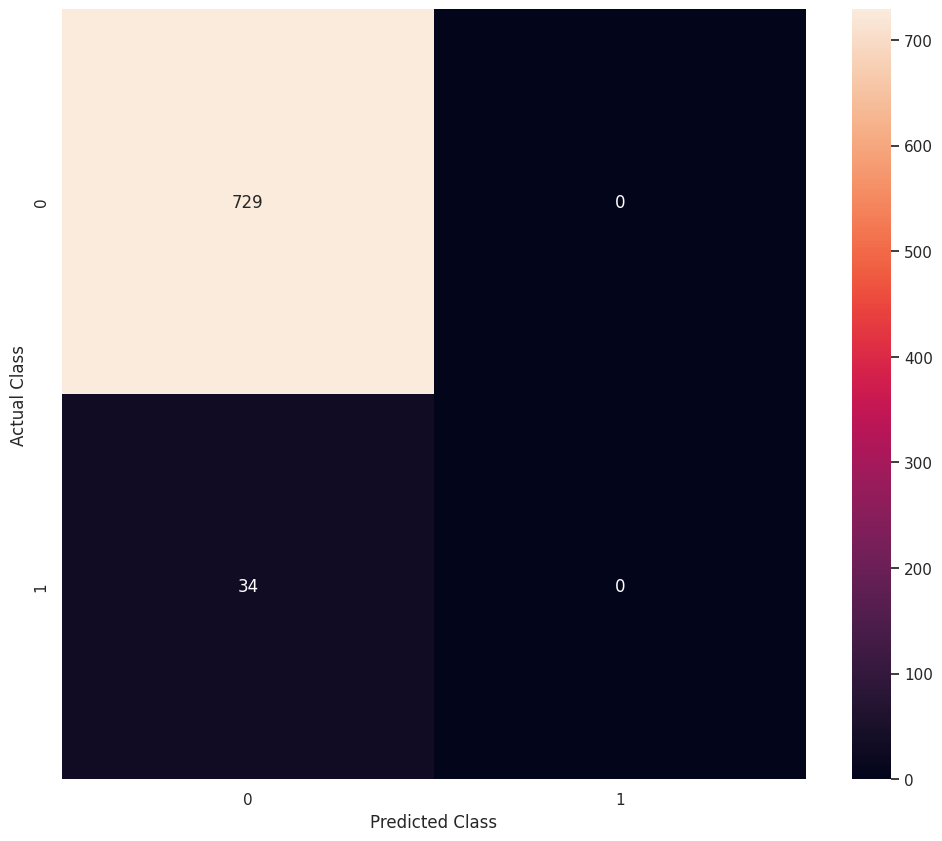

In [255]:
conf_1 = confusion_matrix(yval, cm)

sns.heatmap(conf_1, annot=True, fmt='g')
sns.set(rc={'figure.figsize':(12,10)})
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

In [256]:
print(classification_report(yval,cm))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       729
           1       0.00      0.00      0.00        34

    accuracy                           0.96       763
   macro avg       0.48      0.50      0.49       763
weighted avg       0.91      0.96      0.93       763



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [268]:
elastic_net_classifier.score(xtest, ytest)

0.959349593495935

From the cross validated Logistic Regression, the variables that had the most influence on the regression were BMI, Glucose levels, and age. For every 1 unit change in age, holding other variables constant, the log odds increased by .00492. For every 1 unit change in bmi, holding other variables constant, the log odds decreased by 0.050244. For every 1 unit change in avg_glucose_level, holding other variables constant, the log odds decreased by 0.010765. BMI and Glucose levels had a larger effect on the outcome of a stroke. Predicting someone did not have a stroke but they actually did is a greater cost than predicting someone would get a stroke and they did not. Therefore we would want to use the recall percent. Our recall value is 100%. Our elastic net, cross validated, logistic model may be overfit. 

Random Forest

In [192]:
clf = RandomForestClassifier(n_estimators=100,
                            max_depth=None,
                            oob_score=True,
                            random_state=21)
clf.fit(xtrain,ytrain)
clf.oob_score_

0.9553956834532374

In [193]:
clf.score(xval, yval)

0.9609483960948396

In [194]:
clf.feature_importances_

array([2.25194973e-01, 2.96817496e-02, 2.57874504e-02, 2.83508869e-01,
       2.35748513e-01, 3.32199819e-02, 0.00000000e+00, 1.87976243e-02,
       2.57441224e-06, 2.80582672e-02, 2.04091339e-02, 8.89778172e-04,
       3.45611222e-02, 2.23948986e-02, 2.38549726e-02, 1.78900928e-02])

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few tre

[0.9461870503597122, 0.9355395683453237, 0.937841726618705, 0.9392805755395683, 0.9450359712230216, 0.945611510791367, 0.9433093525179856]


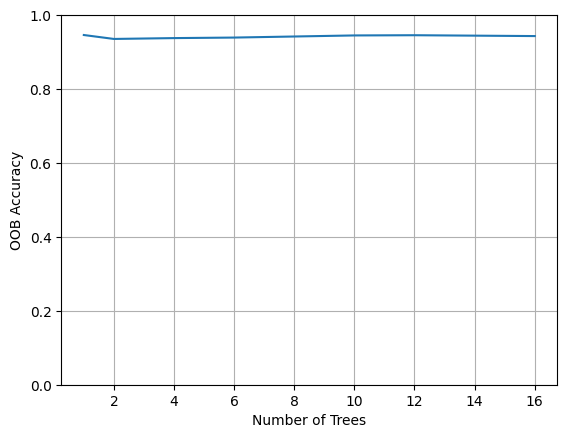

In [195]:
n_trees = [1,2,4,6,10,12,16]

oob_acc = []
for n in n_trees:
    clf = RandomForestClassifier(n_estimators=n,
                                 max_depth=None,
                                 max_features=25,
                                 oob_score=True)
    clf.fit(xtrain,ytrain)
    oob_acc.append(clf.oob_score_)

plt.grid()
plt.ylim([0, 1.0])
plt.plot(n_trees, oob_acc)
plt.xlabel("Number of Trees")
plt.ylabel("OOB Accuracy")
print(oob_acc)

[0.9559712230215828, 0.9548201438848921, 0.9545323741007194, 0.9548201438848921, 0.9551079136690648]


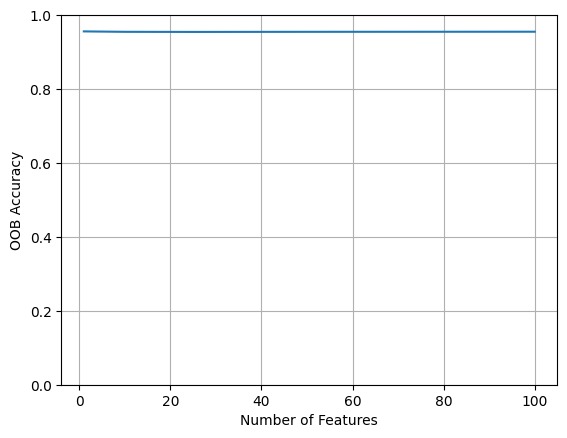

In [196]:
n_features_per_split = [1,10,25,50,100]

oob_acc = []
for n in n_features_per_split:
    clf = RandomForestClassifier(n_estimators=100,
                                 max_depth=None,
                                 max_features=n,
                                 oob_score=True)
    clf.fit(xtrain,ytrain)
    oob_acc.append(clf.oob_score_)

plt.grid()
plt.ylim([0, 1.0])
plt.plot(n_features_per_split, oob_acc)
plt.xlabel("Number of Features")
plt.ylabel("OOB Accuracy")
print(oob_acc)

[0.9571223021582734, 0.9568345323741008, 0.9556834532374101, 0.9545323741007194, 0.9542446043165468, 0.9545323741007194]


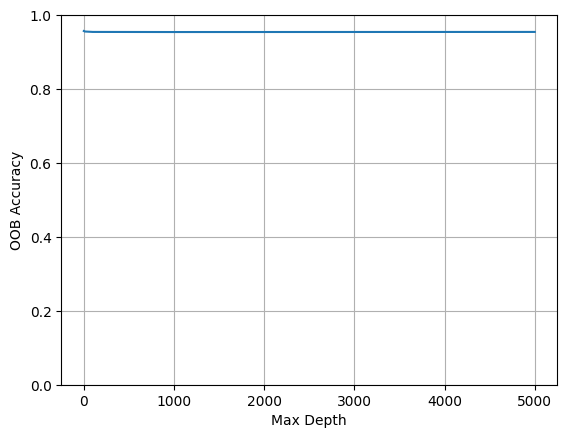

In [197]:
max_depth = [1,5,10,100,1000,5000]

oob_acc = []
for n in max_depth:
    clf = RandomForestClassifier(n_estimators=100,
                                 max_depth=n,
                                 max_features=25,
                                 oob_score=True)
    clf.fit(xtrain,ytrain)
    oob_acc.append(clf.oob_score_)

plt.grid()
plt.ylim([0, 1.0])
plt.plot(max_depth, oob_acc)
plt.xlabel("Max Depth")
plt.ylabel("OOB Accuracy")
print(oob_acc)

In [198]:
columns = list(df)
columns.pop()
print(columns)

['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'gender_Male', 'gender_Other', 'ever_married_Yes', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes']


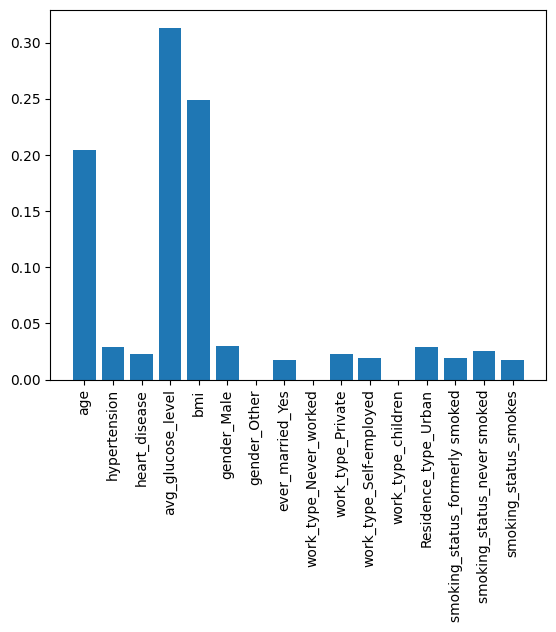

In [199]:
plt.bar(x = columns[:],height=clf.feature_importances_)
plt.xticks(rotation = 90)
plt.show()

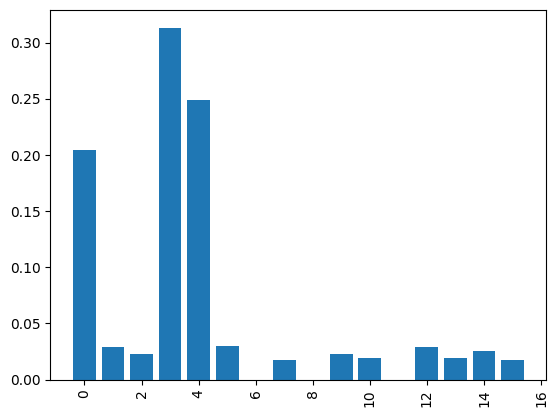

In [200]:
plt.bar(x = np.arange(16),height=clf.feature_importances_)
plt.xticks(rotation = 90)
plt.show()

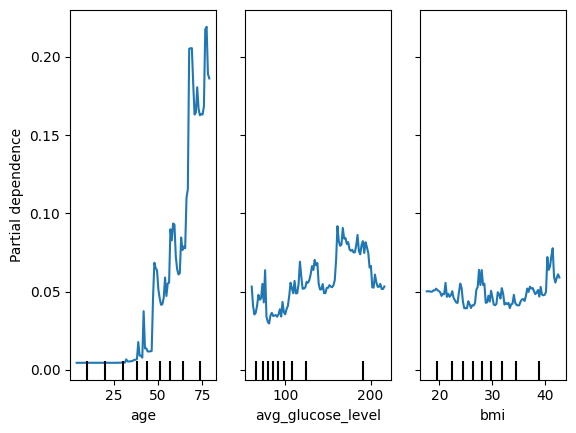

In [201]:
from sklearn.inspection import PartialDependenceDisplay

features = [0,3,4]
PartialDependenceDisplay.from_estimator(clf, xtrain, features)

As age increase there is an increase in the outcome of a stroke. Those with a higher clucose level had a larger affect in stroke risk. Those with a bmi over 40 have a higher stroke risk. 

In [269]:
clf.score(xtest, ytest)

0.989159891598916

SVM

In [258]:
svc = SVC(C=0.01, kernel='linear')
cross_val_score(svc, xtrain, ytrain, cv=5)

array([0.95747801, 0.95747801, 0.95747801, 0.95741557, 0.95741557])

In [259]:
params_grid = [{'kernel': ['rbf'],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

In [260]:
svm_model = GridSearchCV(SVC(), params_grid, cv=5, n_jobs=6, verbose=4)
svm_model.fit(xtrain, ytrain)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=6,
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             verbose=4)

In [261]:
svm_model.cv_results_

{'mean_fit_time': array([2.09411383e-01, 4.81280422e-01, 2.03882885e+00, 1.43406717e+01,
        1.49529650e+02, 2.28299361e+02, 2.31822793e+02, 2.34615245e+02]),
 'std_fit_time': array([6.03455045e-03, 1.13281518e-01, 2.41661528e-01, 1.75736245e+00,
        2.17423452e+01, 2.21914906e+01, 3.46753312e+01, 7.92230236e+01]),
 'mean_score_time': array([0.0625309 , 0.09706764, 0.14484959, 0.09477382, 0.03818445,
        0.03283401, 0.02900357, 0.01265159]),
 'std_score_time': array([0.00935213, 0.03145613, 0.02895225, 0.02507473, 0.01222857,
        0.01271276, 0.00435207, 0.0062462 ]),
 'param_C': masked_array(data=[1, 10, 100, 1000, 1, 10, 100, 1000],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_kernel': masked_array(data=['rbf', 'rbf', 'rbf', 'rbf', 'linear', 'linear',
                    'linear', 'linear'],
              mask=[False, False, False, False, False, False, False, False],
        fil

In [262]:
print('Best score for training data:', svm_model.best_score_)

Best score for training data: 0.957453029657094


In [263]:
print('Best C:',svm_model.best_estimator_.C) 
print('Best Kernel:',svm_model.best_estimator_.kernel)
print('Best Gamma:',svm_model.best_estimator_.gamma)

Best C: 1
Best Kernel: rbf
Best Gamma: scale


In [264]:
final_model = svm_model.best_estimator_
pred = final_model.predict(xval)
pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [265]:
print(confusion_matrix(yval,pred))

[[729   0]
 [ 34   0]]


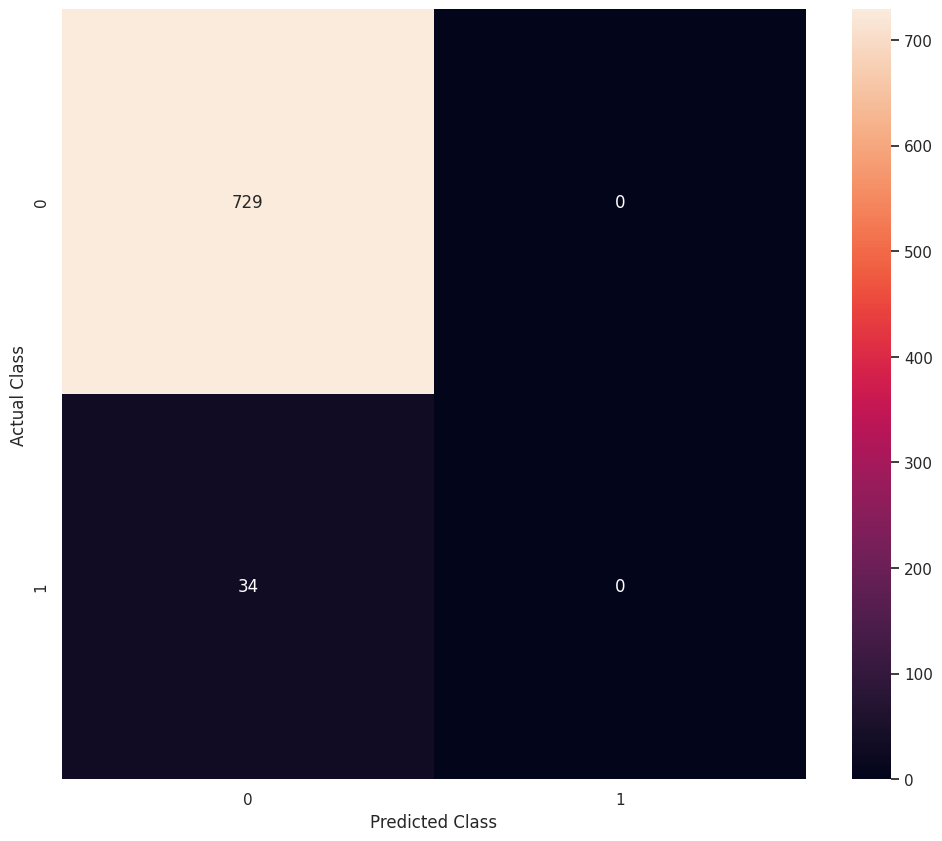

In [266]:
conf_3 = confusion_matrix(yval, pred)

sns.heatmap(conf_3, annot=True, fmt='g')
sns.set(rc={'figure.figsize':(12,10)})
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

In [267]:
print(classification_report(yval,pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       729
           1       0.00      0.00      0.00        34

    accuracy                           0.96       763
   macro avg       0.48      0.50      0.49       763
weighted avg       0.91      0.96      0.93       763



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Based on accuracy, using random forests would be better because we would be able to get over the .957 baseline and peform better than an ordinary elastic net logistic regression. Our SVM model had the same accuracy, precision and recall as the basic elastic net Logistic regression. Since there is a larger cost to human life by predicting false and a patient actually had a stroke, we would want to use the recall value. I wanted to use the elastic net logistic regression model to predict onto our dataset. The value may be over fit to our validation set because the recall value is 100%. 
Testing between models, the random forest had a much higher accuracy on the test set then the logistic elastic net model alone. Both performed over the naive baseline, but we would want to go with random forest to have a higher accuracy of determining when someone has a stroke or not. Random Forest also breaks down what variables were the most helpful to predicting a stroke. SVM has a much longer computation time and so if we had more records or more predictor variables, I would choose the logistic regression model with elastic net over svm itself. 